# Прогнозирование оттока клиентов.  ML
<br>


&nbsp;&nbsp;&nbsp;&nbsp; Предоставлен набор данных от телекоммуникационной компании. В данных содержится информация о почти шести тысячах пользователей, их демографических характеристиках, услугах, которыми они пользуются, длительности пользования услугами оператора, методе оплаты, размере оплаты. 
<br>

&nbsp;&nbsp;&nbsp;&nbsp; Cтоит задача проанализировать данные и спрогнозировать отток пользователей. 
<br><br>


In [4]:
import numpy as np
import pandas as pd
import math
import re
import missingno as msno
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import (train_test_split, cross_val_predict,
                                     StratifiedKFold, RandomizedSearchCV, 
                                     GridSearchCV, cross_val_score) 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import (GradientBoostingClassifier, 
                              StackingClassifier, RandomForestClassifier)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report


# 1. Описание данных

### 1.1 Скачивание и отображение данных:

In [5]:
telecom_users = pd.read_csv('telecom_users.csv')
telecom_users.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No



&nbsp;&nbsp;&nbsp;&nbsp; `customerID` – id клиента<br>
&nbsp;&nbsp;&nbsp;&nbsp; `gender` – пол клиента (male/female)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `SeniorCitizen` – яляется ли клиент пенсионером (1, 0)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Partner` – состоит ли клиент в браке (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Dependents` – есть ли у клиента иждивенцы (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `tenure` – сколько месяцев человек являлся клиентом компании<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PhoneService` – подключена ли услуга телефонной связи (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `MultipleLines` – подключены ли несколько телефонных линий (Yes, No, No phone service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `InternetService` – интернет-провайдер клиента (DSL, Fiber optic, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `OnlineSecurity` – подключена ли услуга онлайн-безопасности (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `OnlineBackup` – подключена ли услуга online backup (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `DeviceProtection` – есть ли у клиента страховка оборудования (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `TechSupport` – подключена ли услуга технической поддержки (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `StreamingTV` – подключена ли услуга стримингового телевидения (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `StreamingMovies` – подключена ли услуга стримингового кинотеатра (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Contract` – тип контракта клиента (Month-to-month, One year, Two year)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PaperlessBilling` – пользуется ли клиент безбумажным биллингом (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PaymentMethod` – метод оплаты (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))<br>
&nbsp;&nbsp;&nbsp;&nbsp; `MonthlyCharges` – месячный размер оплаты на настоящий момент<br>
&nbsp;&nbsp;&nbsp;&nbsp; `TotalCharges` – общая сумма, которую клиент заплатил за услуги за все время<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Churn` – произошел ли отток (Yes or No)<br>

In [4]:
telecom_users_original = telecom_users.copy()

In [6]:
telecom_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


### 1.2 Корректировка данных:

In [6]:
# перевод значений TotalCharges в float

telecom_users['TotalCharges']= [float(x) if re.match(r'\d+', x) else 0 for x in telecom_users['TotalCharges']]


# выъявление пропущенных значений в TotalCharges

telecom_users[telecom_users['TotalCharges'] == 0] 

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
356,6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,0.0,No
634,1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0.0,No
2771,3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0.0,No
3086,5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0.0,No
3255,3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0.0,No
4326,936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0.0,No
5375,753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0.0,No
5382,4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0.0,No
5695,488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,No
5951,1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0.0,No


Судя по данным, пустые позиции в TotalCharges образовались из-за нулевых в tenure, то есть можно предположить, что речь идет о новых клиентах с контрактами, заключенными менее месяца назад.

Поскольку остальные данные по этим клинетам заполнены, можно значения TotalCharges принять как в MonthlyCharges, а tenure, равные 1.

In [7]:
telecom_users['TotalCharges'] = telecom_users.apply(lambda x: x['MonthlyCharges'] if (x['TotalCharges'] == 0)\
                                                                                 else x['TotalCharges'], axis=1)

telecom_users['tenure'] = telecom_users.apply(lambda x: 1 if (x['tenure'] == 0)\
                                                         else x['tenure'], axis=1)

# Data with names for vizualization
data_features = telecom_users.copy()

___

### 1.3  Расчет базовых статистик и визуализация данных:

In [244]:
telecom_users.describe(include=[np.object])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986,5986
unique,5986,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,5611,2
top,3077-RSNTJ,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No
freq,1,3050,3082,4195,5396,2848,2627,2982,2605,2640,2960,2389,2356,3269,3528,2006,10,4399


In [315]:
telecom_users.describe(include=[np.number])

,Unnamed: 0,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000
mean,3533.561310,0.161377,32.470431,64.802213,2294.285416
std,2035.705666,0.367909,24.514212,30.114702,2274.100395
min,0.000000,0.000000,1.000000,18.250000,18.800000
25%,1777.250000,0.000000,9.000000,35.650000,401.587500
50%,3546.500000,0.000000,29.000000,70.400000,1408.575000
75%,5291.750000,0.000000,56.000000,89.900000,3841.500000
max,7042.000000,1.000000,72.000000,118.750000,8684.800000


Замена категориальных признаков на числовые значения:

In [8]:
telecom_users.drop(['Unnamed: 0', 'customerID'], axis = 'columns', inplace=True)

obj_columns = telecom_users.select_dtypes(include=[np.object]).columns
telecom_users[obj_columns] = telecom_users [obj_columns].astype('category').apply(lambda x: x.cat.codes)

telecom_users

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,1,72,1,2,2,1,1,1,1,1,1,2,0,1,24.10,1734.65,0
1,0,0,0,0,44,1,0,1,0,2,2,0,2,0,0,1,1,88.15,3973.20,0
2,0,1,1,0,38,1,2,1,0,0,0,0,0,0,0,1,0,74.95,2869.85,1
3,1,0,0,0,4,1,0,0,0,0,0,0,0,2,0,1,2,55.90,238.50,0
4,1,0,0,0,2,1,0,0,2,0,2,0,0,0,0,0,2,53.45,119.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,1,0,1,0,1,1,0,1,2,0,0,0,2,2,0,1,2,95.00,95.00,1
5982,0,0,1,1,23,1,2,0,2,2,2,2,2,2,2,1,1,91.10,2198.30,0
5983,1,0,1,1,12,1,0,2,1,1,1,1,1,1,0,1,2,21.15,306.05,0
5984,1,1,0,0,12,1,2,1,0,0,2,0,2,2,0,1,2,99.45,1200.15,1


In [83]:
telecom_users.describe(include=[np.number])

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000
mean,0.509522,0.161377,0.485132,0.299198,32.470431,0.901437,0.949883,0.870197,0.788005,0.913966,0.902272,0.795356,0.986134,0.997160,0.694621,0.589375,1.574006,64.802213,2294.285416,0.265119
std,0.499951,0.367909,0.499821,0.457945,24.514212,0.298100,0.948196,0.737824,0.859949,0.881509,0.880289,0.861728,0.885590,0.885694,0.832884,0.491988,1.067302,30.114702,2274.100395,0.441433
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.650000,401.587500,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,70.400000,1408.575000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,56.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,89.900000,3841.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,1.000000


Визуализация данных:

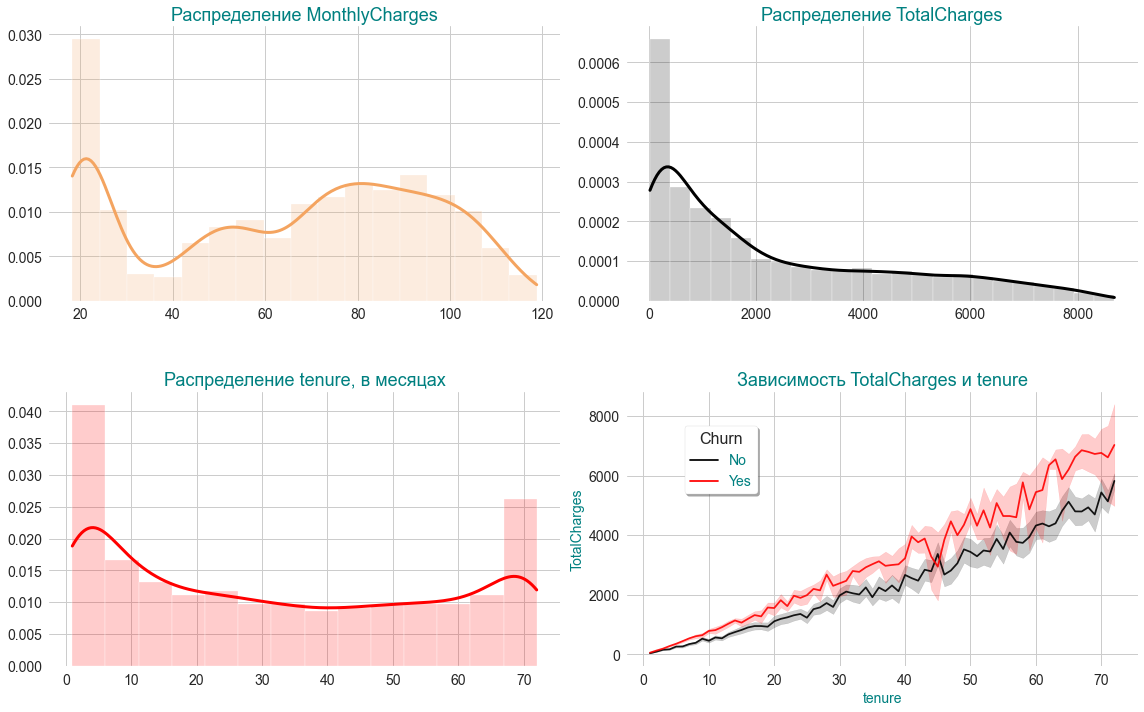

In [84]:
plt.style.use('seaborn')
sns.set_style("whitegrid")

fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.histplot(telecom_users['MonthlyCharges'],  kde=True, stat="density", line_kws = dict(linewidth=3),
             color='sandybrown', alpha=0.2)
ax1.set_title("Распределение MonthlyCharges",
             fontsize=18, color='teal')
ax1.set_xlabel(None)
ax1.set_ylabel(None)
ax1.tick_params(labelsize=14)

ax2 = fig.add_subplot(2, 2, 2)  
ax2 = sns.histplot(telecom_users['TotalCharges'],  kde=True, stat="density", line_kws = dict(linewidth=3),
             color='black', alpha=0.2)
ax2.set_title("Распределение TotalCharges",
             fontsize=18, color='teal')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.tick_params(labelsize=14)

ax3 = fig.add_subplot(2, 2, 3)  
ax3 = sns.histplot(telecom_users['tenure'], kde=True, stat="density", line_kws = dict(linewidth=3),
             color='red', alpha=0.2)
ax3.set_title("Распределение tenure, в месяцах",
             fontsize=18, color='teal')
ax3.set_xlabel(None)
ax3.set_ylabel(None)
ax3.tick_params(labelsize=14)

ax4 = fig.add_subplot(2, 2, 4) 
ax4 = sns.lineplot(data=data_features, x='tenure', y='TotalCharges',  hue='Churn', 
                   palette=['black', 'red'], alpha=0.9)
ax4.set_title("Зависимость TotalCharges и tenure",
             fontsize=18, color='teal')
ax4.set_xlabel('tenure', fontsize=14, color='teal')
ax4.set_ylabel('TotalCharges', fontsize=14, color='teal')
ax4.legend (loc='best', bbox_to_anchor=(0.1, 0.5, 0.17, 0.4), 
           fontsize=14,  labelcolor='teal', #ncol=2,
           shadow=True,  title='Churn', title_fontsize=16, frameon=True)
ax4.tick_params(labelsize=14)

plt.tight_layout(h_pad=5.0) 
             
plt.show()

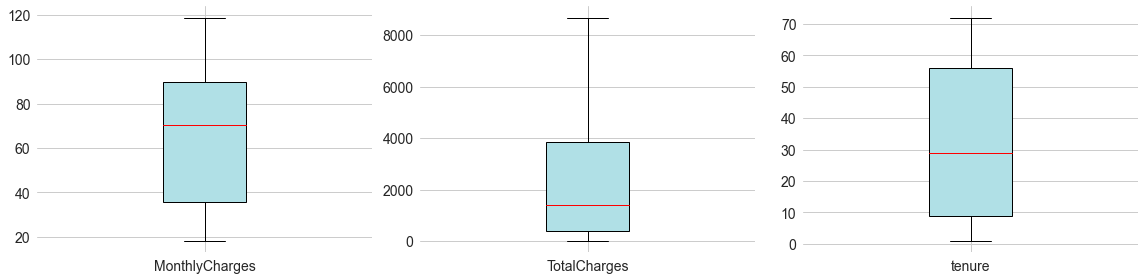

In [85]:
dt = telecom_users[['MonthlyCharges', 'TotalCharges', 'tenure']]

fig = plt.figure(figsize=(16,4))

for column in dt:
    n = list(dt).index(column)
    ax = fig.add_subplot(1, 3, (n+1))
    ax = dt.boxplot(column, meanline=True, color='black', fontsize=14,  widths=0.25, patch_artist=True,
                    boxprops=dict(facecolor='powderblue', color='black'),
                    medianprops=dict(color='red'))

plt.tight_layout(h_pad=5.0)     
plt.show()   

### 1.4 Выводы на основе представленных данных:

**Информация о клиентах компании:**

In [86]:
total = len(telecom_users)

females = telecom_users.gender.sum()

SeniorCitizens = telecom_users.SeniorCitizen.sum()

WithPartner = telecom_users.Partner.sum()

WithDependents = telecom_users.Dependents.sum()

Churn = telecom_users.Churn.sum()


print('Всего клиентов: ', total, 
      '\nв том числе: \n\nженщин        ',  females, ", {:.0%}".format(females/total),
      '\nпенсионеров   ', SeniorCitizens, ",  {:.0%}".format(SeniorCitizens/total),
      '\nв партнерстве ', WithPartner, ", {:.0%}".format(WithPartner/total),
      '\nс иждивенцами ', WithDependents, ", {:.0%}".format(WithDependents/total),
      '\nотток         ', Churn, ", {:.0%}".format(Churn/total))

Всего клиентов:  5986 
в том числе: 

женщин         3050 , 51% 
пенсионеров    966 ,  16% 
в партнерстве  2904 , 49% 
с иждивенцами  1791 , 30% 
отток          1587 , 27%


---

# 2. Исследование зависимостей и формулирование гипотез

### 2.1 Визуализация зависимостей Churn и других признаков

In [13]:
#удаление ненужных признаков
data = data_features.drop(['Unnamed: 0', 'customerID', 'TotalCharges'], axis = 'columns')

#сокращение для удобства наименований в PaymentMethod
data['PaymentMethod'] = data['PaymentMethod'].apply(lambda x: x.split('(')[0])
data.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card,24.10,No
1,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card,88.15,No
2,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer,74.95,Yes
3,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,No
4,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,No


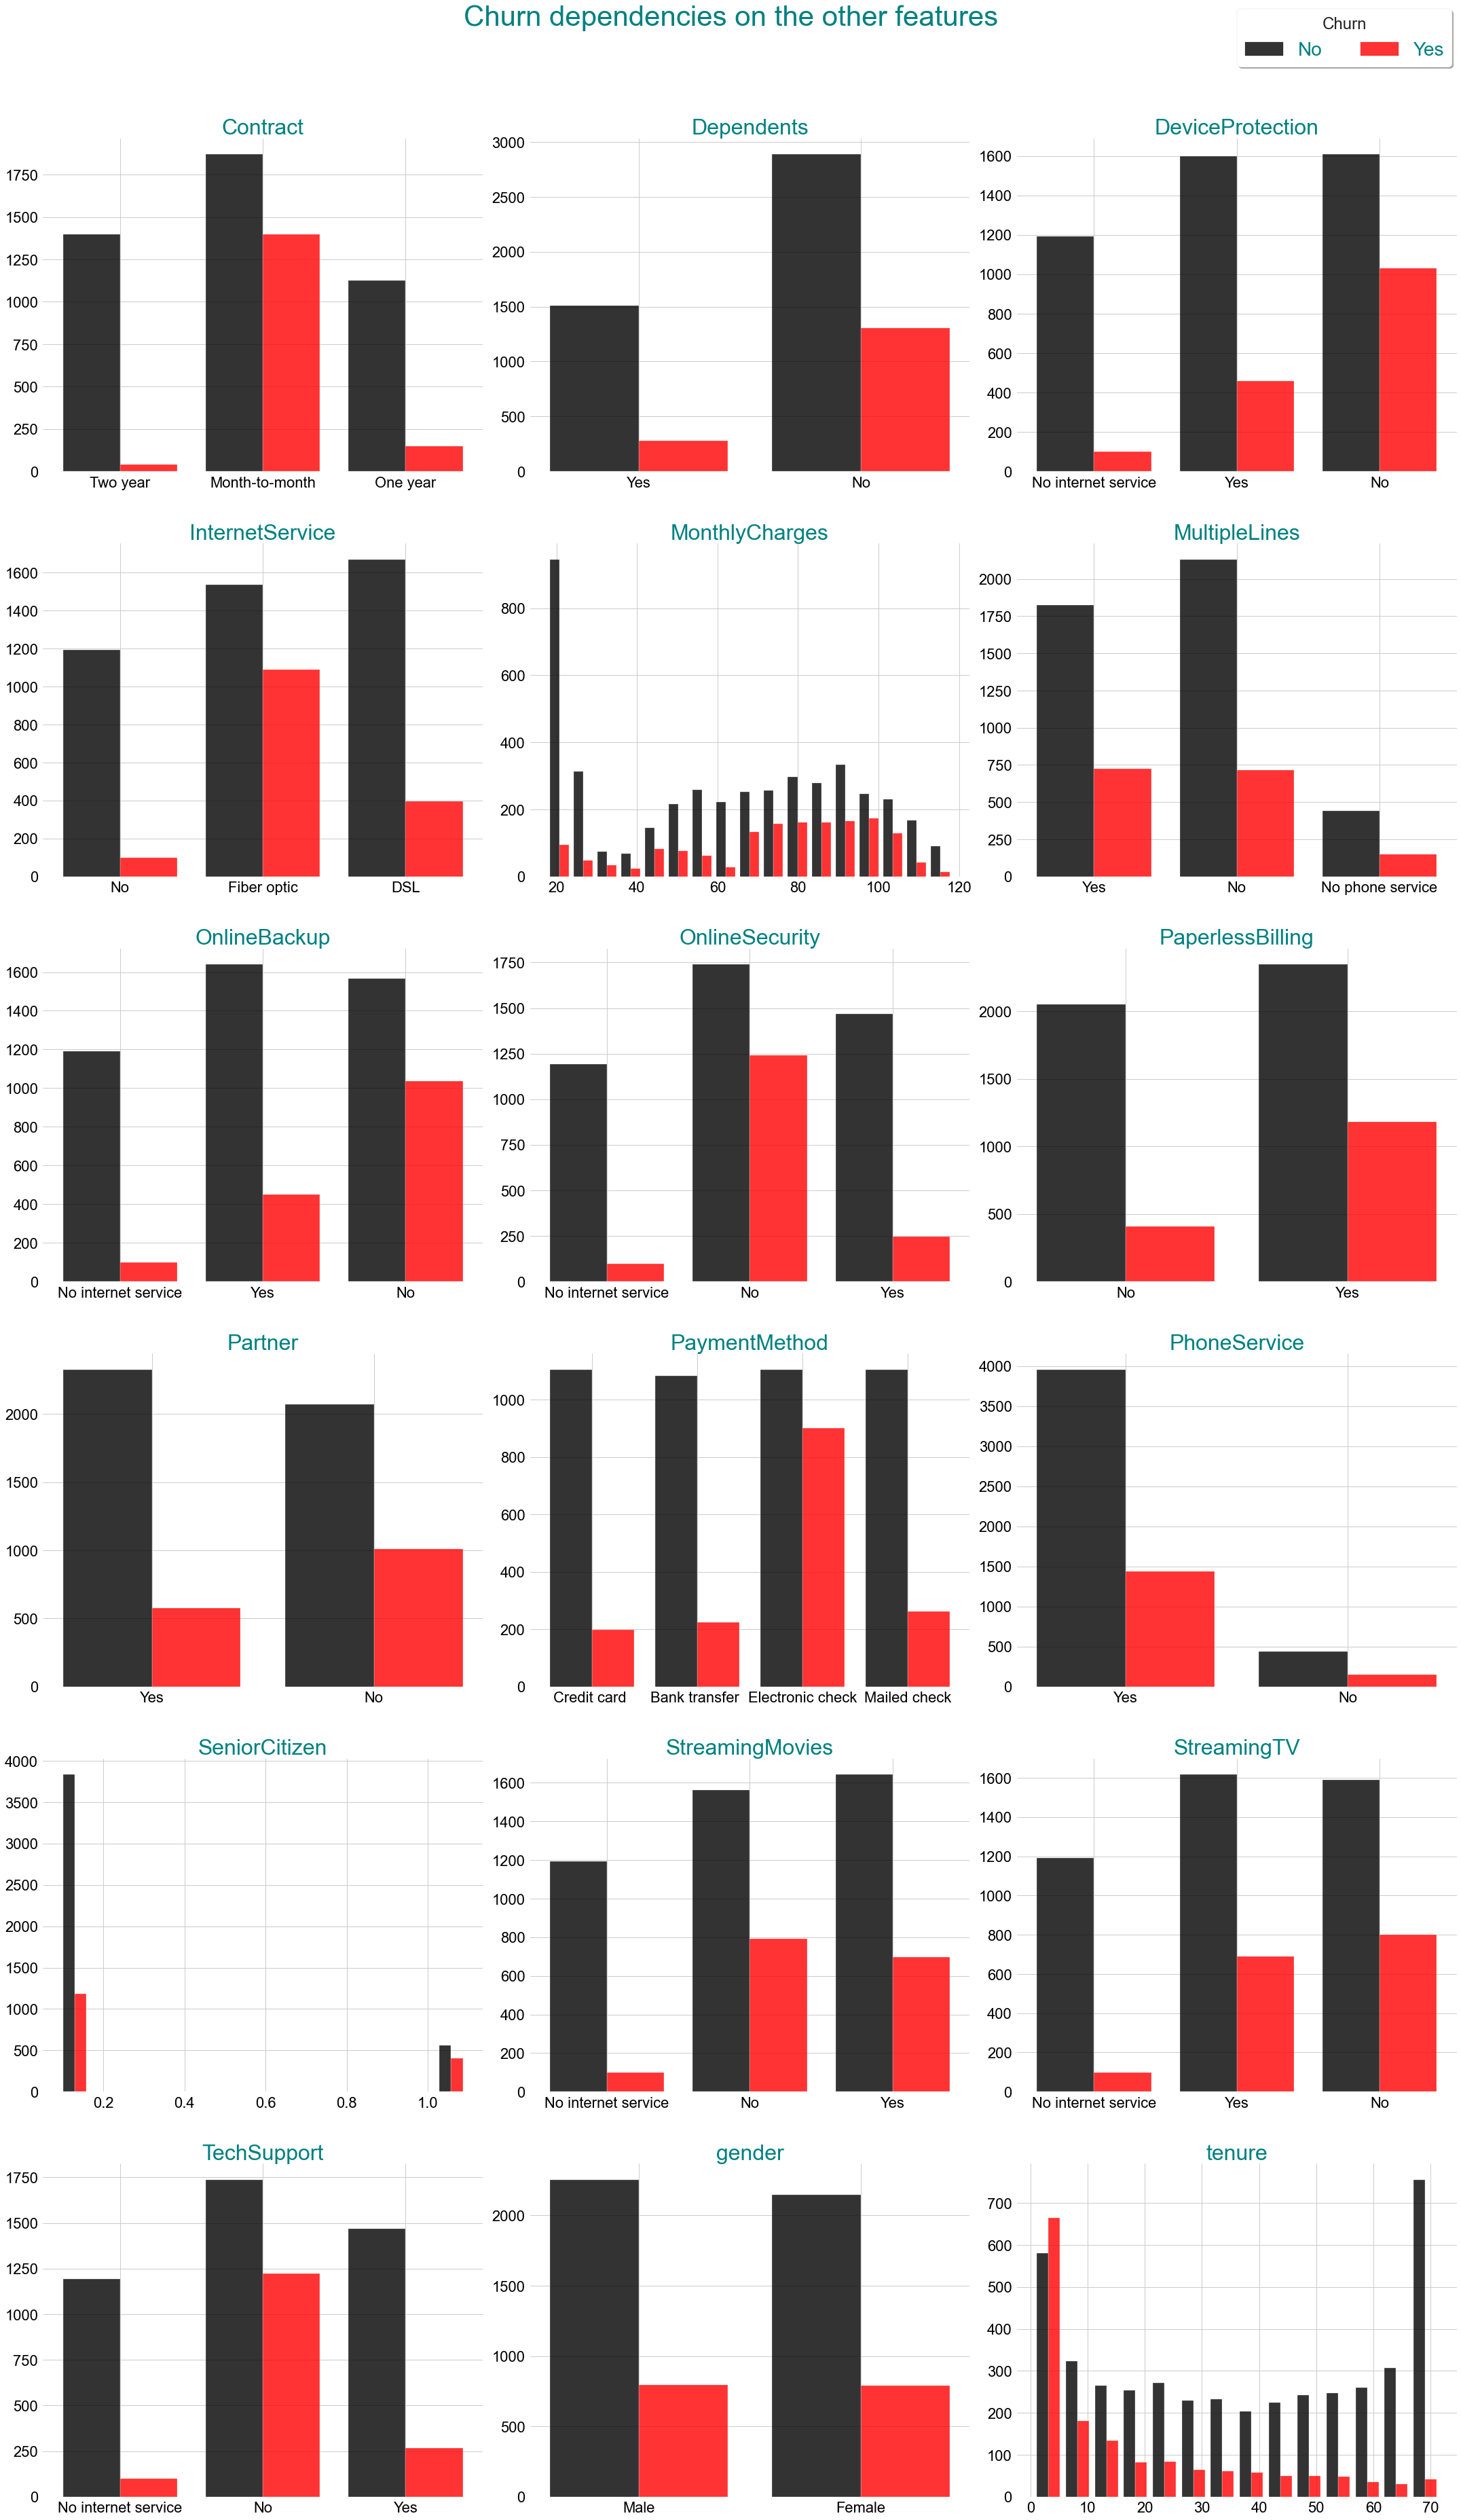

In [16]:
palette = ['black', 'red']
colors = dict(zip(data.Churn.unique(), palette))
              
patchList = []
for key in colors:
        data_key = mpatches.Patch(color=colors[key], label=key, alpha=0.8)
        patchList.append(data_key)


fig = plt.figure()
sns.set_style("whitegrid")

fig.suptitle('Churn dependencies on the other features',
             y = 1.03, fontsize=42, c='teal')


for column in data.columns.difference(['Churn']):
    n = list(data.columns.difference(['Churn'])).index(column)
    ax = fig.add_subplot(6, 3, (n+1))
    ax = sns.histplot(data=data, x=column, hue='Churn', legend=None, palette= palette,
                      alpha=0.8,  multiple='dodge', shrink=.8)
    ax.set_title(column, fontsize=32,  c='teal') #, fontweight='bold')
    ax.tick_params(labelsize = 22,labelcolor = 'black',
                   bottom=False, left=False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine(left=True)
    fig.set_figwidth(30)
    fig.set_figheight(50)
    plt.tight_layout(h_pad=5.0) 
      
fig.legend(handles = patchList, loc=1, 
            fontsize=28,  labelcolor='teal', ncol=2, frameon=True,
            shadow=True,  title='Churn', title_fontsize=24)

plt.show()

### 2.2 Формулирование гипотез

На данном этапе можно выделить следующие признаки, предположительно влияющие на отток клиентов:
    
   - **Contract** (тип контракта Month-to-month);
   - **DeviceProtection** (отказываются чаще те, у кого отсутствует);
   - **InternetService** (тип Fiber optic);
   - **OnlineSecurity** (отказываются чаще те, у кого отсутствует);
   - **PaymentMethod** (тип Electronic check);
   - **SeniorCitizen**;
   - **TechSupport** (отказываются чаще те, у кого отсутствует);
   - **tenure** (отток чаще в первые 10 месяцев).

---

### 2.3  Отбор признаков, имеющих наиболее тесные взаимосвязи с Churn:

Разбиение данных на тестовые и тренировочные:

In [17]:
features_data = telecom_users.drop(columns='Churn')
churn = telecom_users.Churn

x_train, x_test, y_train, y_test = train_test_split(features_data, 
                                                    churn,
                                                    train_size=0.8,
                                                    random_state=17)

В качестве метрики оценки важности признаков в XGBoost используем F-score, которая вычисляется на основе того, как часто делалось разбиение по данному признаку.

In [18]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'objective': 'binary:logistic',
          'max_depth': 3,
          'eta': 0.1}

num_rounds = 60

xgb_model_f = xgb.train(params, dtrain, num_boost_round = 60)

[18:04:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [19]:
evallist = [(dtest, 'test'), (dtrain, 'train')]
xgb_model_f = xgb.train(params, dtrain, num_boost_round = 60, evals = evallist)

[18:04:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.65297	train-logloss:0.65200
[1]	test-logloss:0.62155	train-logloss:0.61928
[2]	test-logloss:0.59409	train-logloss:0.59090
[3]	test-logloss:0.57185	train-logloss:0.56789
[4]	test-logloss:0.55226	train-logloss:0.54751
[5]	test-logloss:0.53616	train-logloss:0.53014
[6]	test-logloss:0.52239	train-logloss:0.51571
[7]	test-logloss:0.51014	train-logloss:0.50277
[8]	test-logloss:0.49991	train-logloss:0.49195
[9]	test-logloss:0.49086	train-logloss:0.48214
[10]	test-logloss:0.48230	train-logloss:0.47390
[11]	test-logloss:0.47517	train-logloss:0.46663
[12]	test-logloss:0.46938	train-logloss:0.46027
[13]	test-logloss:0.46385

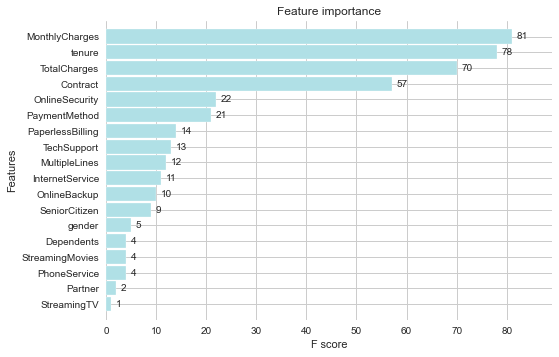

In [20]:
xgb.plot_importance(xgb_model_f, height=0.9, color = 'powderblue')  
plt.show()                                                          

### 2.4 Определение наиболее зависимых друг от друга признаков

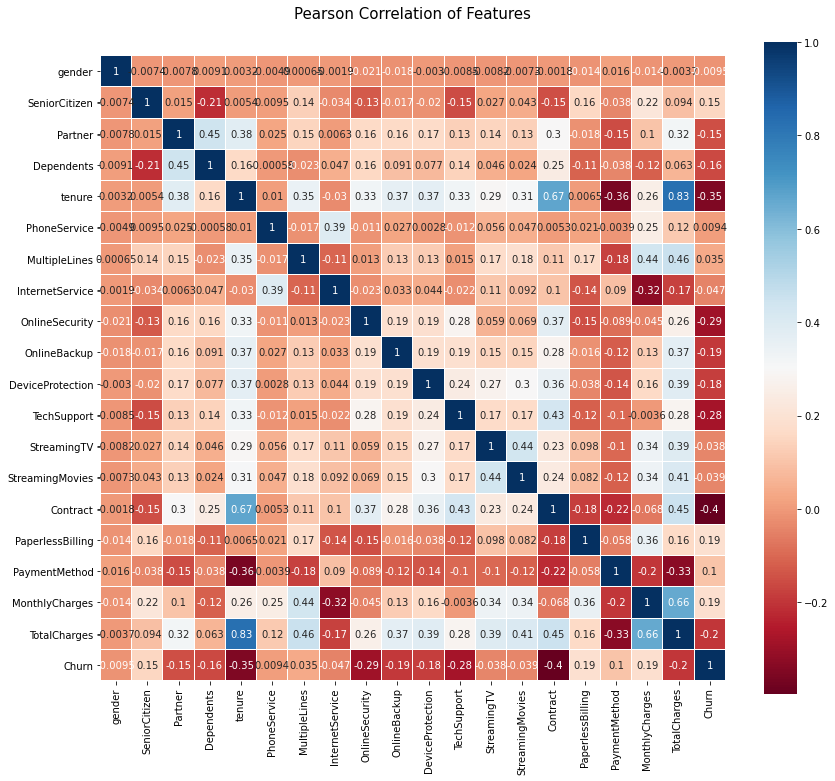

In [10]:
colormap = plt.cm.RdBu  #curl
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(telecom_users.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

Заметно, что зависимость  между tenure и TotalCharges довольная высока (0.83), следовательно один из них можно не включать в данные для создания модели.

### 2.5 Удаление характеристик, либо не влияющих на отток, либо дублирующих зависимость с другими признаками.

Оставляю признаки с наибольшим  F-score и удаляю TotalCharges:

In [13]:
data_for_learners = telecom_users[['MonthlyCharges', 'tenure',  'Contract', 'MultipleLines', 'InternetService', #'TotalCharges',
                           'OnlineSecurity', 'PaymentMethod', 'PaperlessBilling', 'TechSupport',
                           'OnlineBackup', 'SeniorCitizen', 'Churn']]
#Признаки
features = data_for_learners.drop(columns='Churn')

#Целевая переменная 
churn = telecom_users.Churn

# 3. Построение моделей для прогнозирования оттока

Разбиение данных на тестовые и тренировочные:

In [118]:
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    churn,
                                                    train_size=0.8,
                                                    stratify=churn,
                                                    random_state=17)

### 3.1 Модель [ 1 ] на основе базового алгоритма классификации DecisionTree.

Построение и обучение модели:

In [136]:
tree = DecisionTreeClassifier(criterion = "entropy", max_depth=5, random_state=17)
tree.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=17)

Подбор лучшего сочетания параметров, используя обученное дерево решений на 5-кратной валидации с помощью GridSearchCV:

In [137]:
tree_params = {'max_depth': range(1,11),
               'max_features': range(2,19),
               'min_samples_leaf': range(2,6),
               'min_samples_split': range(2,5)}


tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=4,
                         verbose=True)

tree_grid.fit(x_train, y_train)

#лучшее сочетание параметров с помощью метода tree_grid.best_params_
tree_grid.best_params_

Fitting 5 folds for each of 2040 candidates, totalling 10200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 4368 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done 10200 out of 10200 | elapsed:   27.2s finished


{'max_depth': 6,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [138]:
tree_grid.best_score_

0.7903135450684223

Построение и обучение модели с подобранными параметрами:

In [140]:
tree_ = DecisionTreeClassifier(criterion = "entropy", max_depth=6, max_features=4, min_samples_split=2,
                               min_samples_leaf = 2, 
                               random_state=17)
                               
tree_.fit(x_train, y_train)

#прогноз для тестовой выборки данных
tree_pred = tree_.predict(x_test)

#определение точности модели
print(f'\nClassification_report:\n {classification_report(y_test, tree_pred)}')


#вероятности принадлежности объектов тестовой выборки к классам
tree_proba_ = tree_.predict_proba(x_test)

auc_tree_proba = roc_auc_score(y_test, tree_proba_[:, 1])
print(f'\nAUC-ROC_tree_proba: {auc_tree_proba}')



Classification_report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87       880
           1       0.65      0.48      0.55       318

    accuracy                           0.79      1198
   macro avg       0.74      0.69      0.71      1198
weighted avg       0.78      0.79      0.78      1198


AUC-ROC_tree_proba: 0.8335388078902229


### 3.2 Модель [ 2 ].  XGBoost (eXtreme Gradient Boosting) на основе базовых алгоритмов - DecisionTree.

Подбор наилучших гиперпараметров с помощью RandomizedSearchCV с cv=5 (Finding the best params):

In [119]:
params = {
    #criterion='friedman_mse'
    'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    "max_depth": [1, 2, 4, 6, 10],
    "learning_rate": [0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 1],
    "colsample_bytree":[1, .8, .5],
    "subsample": [0.8],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'n_estimators': [10, 20, 30, 60, 100, 1000]
}

folds = 5
max_models = 5



xgb_algo = xgb.XGBClassifier()


random_search = RandomizedSearchCV(xgb_algo,
                               param_distributions=params,  
                               n_iter=max_models, 
                               scoring= 'roc_auc', n_jobs=4, cv=5,  
                               verbose=False, random_state=17, refit=False )

random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                   param_distributions={'colsample_bytree': [1, 0.8, 0.5],
                                        'gamma': [0, 0.25, 0.5, 1.0],
                                    

In [17]:
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best hyperparameters:
{'subsample': 0.8, 'reg_lambda': 10.0, 'n_estimators': 1000, 'min_child_weight': 7.0, 'max_depth': 1, 'learning_rate': 0.4, 'gamma': 0.25, 'colsample_bytree': 0.8}


Построение и обучение модели с подобранными параметрами:

In [126]:
xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.25, learning_rate=0.4,
       max_delta_step=0, max_depth=1, min_child_weight=7, missing=None,
       n_estimators=1000, n_jobs=4, objective='binary:logistic',
       random_state=17, reg_alpha=0, reg_lambda=10, scale_pos_weight=2.77,
       seed=None, subsample=0.8, use_label_encoder =False)

xgb_model.fit(x_train, y_train)


#прогноз для тестовой выборки данных
pred = xgb_model.predict(x_test)

report_xgbc = classification_report(y_test, pred)
print(f'\nclassification_report:\n {report_xgbc}')


#вероятности принадлежности объектов тестовой выборки к классам
xgbc_proba_ = xgb_model.predict_proba(x_test)

auc_xgbc_proba = roc_auc_score(y_test, xgbc_proba_[:, 1])
print(f'\nAUC-ROC_xgbc_proba: {auc_xgbc_proba}')


[13:26:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

classification_report:
               precision    recall  f1-score   support

           0       0.92      0.71      0.80      1100
           1       0.50      0.82      0.62       397

    accuracy                           0.74      1497
   macro avg       0.71      0.76      0.71      1497
weighted avg       0.81      0.74      0.75      1497


AUC-ROC_xgbc_proba: 0.8425807190290819


 ### 3.3 Модель [ 3 ]. XGBoost с использованием объектов DMatrix.

In [133]:
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    churn,
                                                    train_size=0.8,
                                                    stratify=churn,
                                                    random_state=17)

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

Так как выборка несбалансированная, использую параметр set_pos_weight для контроля соотношение числа объектов разных классов:

In [134]:
ratio = np.sum(dtrain.get_label() == 0) / np.sum(dtrain.get_label() == 1)
ratio

2.773049645390071

In [135]:
params = {'objective': 'binary:logistic', 
          'scale_pos_weight': ratio,
          'max_depth': 1, 
          'eta': 1}

num_boost_round = 100

xgb_model = xgb.train(params, dtrain, num_boost_round = 100)

#прогноз для тестовой выборки данных
pred = xgb_model.predict(dtest)
mtrx_pred = pred > 0.5

report_xgboost = classification_report(y_test, mtrx_pred)
print(f'\nClassification_report:\n {report_xgboost}')


#вероятности принадлежности объектов тестовой выборки к классам
pred = xgb_model.predict(dtest)

auc_xgb_proba = roc_auc_score(y_test, pred)
print(f'\nAUC-ROC_xgb_proba: {auc_xgb_proba}')

[13:40:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Classification_report:
               precision    recall  f1-score   support

           0       0.92      0.69      0.79       880
           1       0.50      0.84      0.62       318

    accuracy                           0.73      1198
   macro avg       0.71      0.77      0.71      1198
weighted avg       0.81      0.73      0.75      1198


AUC-ROC_xgb_proba: 0.8549296026300743


 Теперь вместо параметра set_pos_weight зададим вручную веса для экземпляров классов:

In [132]:
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    churn,
                                                    train_size=0.8,
                                                    stratify=churn,
                                                    random_state=17)

weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 2


dtrain = xgb.DMatrix(x_train, y_train, weight = weights)
dtest = xgb.DMatrix(x_test, y_test)

params = {'objective': 'binary:logistic',
          'max_depth': 1, 
          'eta': 1}

xgb_model = xgb.train(params, dtrain, num_boost_round = 30)

#прогноз для тестовой выборки данных
pred = xgb_model.predict(dtest)
mtrx_pred = pred > 0.5

report_xgboost = classification_report(y_test, mtrx_pred)
print(f'\nClassification_report:\n {report_xgboost}')


#вероятности принадлежности объектов тестовой выборки к классам
pred = xgb_model.predict(dtest)

auc_xgb_proba = roc_auc_score(y_test, pred)
print(f'\nAUC-ROC_xgb_proba: {auc_xgb_proba}')



[13:34:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Classification_report:
               precision    recall  f1-score   support

           0       0.90      0.79      0.84       880
           1       0.56      0.77      0.65       318

    accuracy                           0.78      1198
   macro avg       0.73      0.78      0.74      1198
weighted avg       0.81      0.78      0.79      1198


AUC-ROC_xgb_proba: 0.8552065465980561


### 3.4 Модель [ 4 ]. Стекинг, включающий в себя базовые модели.

In [123]:
#Разделение на тренировочные и тестовые данные
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    churn,
                                                    stratify=churn,
                                                    random_state=17)

##Построение и обучение модели
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=17)),
              ('svr', make_pipeline(StandardScaler(),
                      LinearSVC(random_state=17)))]
clf = StackingClassifier(
          estimators=estimators, final_estimator=LogisticRegression())

clf_model = clf.fit(x_train, y_train)  


#прогноз для тестовой выборки данных
clf_pred = clf_model.predict(x_test)

roc_auc_stacking = roc_auc_score(y_test, clf_pred)
print(f'\nClassification_report:\n {classification_report(y_test, clf_pred)}')


#вероятности принадлежности объектов тестовой выборки к классам
clf_proba = clf_model.predict_proba(x_test)

auc_clf_proba = roc_auc_score(y_test, clf_proba_[:, 1])
print(f'\nAUC-ROC_clf_proba: {auc_clf_proba}')



Classification_report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1100
           1       0.66      0.52      0.58       397

    accuracy                           0.80      1497
   macro avg       0.75      0.71      0.73      1497
weighted avg       0.79      0.80      0.79      1497


AUC-ROC_clf_proba: 0.841662468513854


### 3.5 Модель [ 5 ]. на основе базового алгоритма классификации LogisticRegression

In [97]:
#Разделение на тренировочные и тестовые данные
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    churn,
                                                    test_size = 0.25,
                                                    random_state=17)

In [99]:
#настройкa гиперпараметров с помощью LogisticRegressionCV

cv_v = StratifiedKFold(n_splits=5, random_state=17)
cs = np.logspace(-1, 2, num = 500)

lr_cv = LogisticRegressionCV(Cs = cs, cv = cv_v, scoring = "roc_auc", random_state = 17)
lr_cv_model = lr_cv.fit(x_train, y_train)

lr_cv_model.C_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

array([2.04466067])

In [111]:
# Построение и обучение модели c C=2.04
lr = LogisticRegression(C = 2.04,  random_state = 17)
lr_model = lr.fit(x_train, y_train)  


#прогноз для тестовой выборки данных
lr_pred = lr_model.predict(x_test)

roc_auc_lr = roc_auc_score(y_test, lr_pred)
print(f'\nClassification_report:\n {classification_report(y_test, lr_pred)}')


#вероятности принадлежности объектов тестовой выборки к классам
lr_proba_ = lr_model.predict_proba(x_test)

auc_lr_proba = roc_auc_score(y_test, lr_proba_[:, 1])
print(f'\nAUC-ROC_lr_proba: {auc_lr_proba}')



Classification_report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1115
           1       0.60      0.51      0.55       382

    accuracy                           0.79      1497
   macro avg       0.72      0.70      0.71      1497
weighted avg       0.78      0.79      0.78      1497


AUC-ROC_lr_proba: 0.8239992487028385


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# 4. Сравнение качества моделей 

Оценки качества полученных моделей. Сравнение метрик ROC AUC вероятностей принадлежности объектов тестовой выборки к классам:

In [142]:
score_data = pd.DataFrame({'ROC-AUC_proba': [auc_tree_proba, auc_xgbc_proba, auc_xgb_proba,
                                             auc_clf_proba, auc_lr_proba]},
                           index = ['[Model 1]', '[Model 2]', '[Model 3]', '[Model 4]', '[Model 5]'])
score_data

,ROC-AUC_proba
[Model 1],0.833539
[Model 2],0.842581
[Model 3],0.854930
[Model 4],0.841662
[Model 5],0.823999


Как видно по представленным метрикам качества, наиболее эффективными оказались модели c применением бустинга на основе базового алгоритма - деревья решений:

    [2] XGBoost              ROC-AUC_proba = 0.843 
    [3] XGBoost с DMatrix   ROC-AUC_proba = 0.855 
    
Лучшая модель - Model [3].

# 5. Общие выводы работы:

Информация о клиентах компании:

Всего содержится данных о **5986** клиентах компании, из которых **27%** представляют **отток**.

Количество **женщин и мужчин**  практически **одинаковое**.

**Пенсионеры** составляют **16%**.

**Половина** клиентов состоят в **партнерстве(браке)**.

Несут ответственность за **иждивенцов** **30%**.

---

**Услуги, стоимость и продолжительность контрактов:**

Наиболее популярной услугой среди пользователей является **PhoneService**.

Выбирая **InternetService**,  чаще всего это - **Fiber optic**.

Больше половины клиентов отказываются от **OnlineSecurity**, **OnlineBackup**, **DeviceProtection**, **TechSupport**, **StreamingTV**,	**StreamingMovies**.

Contract чаще всего заключается **Month-to-month**, а оплата производится методом **Electronic check** и **PaperlessBilling**.

Большинство является клиентами:
- от **1 месяца** до **2 лет** или свыше **5 лет**.

Платежеспособность клиентов в основном составляет:
- до **2500** руб (за весь период обслуживания);
- от **18 до 30** руб и от **70 до 105** руб в месяц.

---

На основе визуализации зависимостей оттока от других признаков, можно было сформулировать следующие гипотезы. Отток наиболее зависим от:

   - **Contract** (тип контракта Month-to-month);
   - **DeviceProtection** (отказываются чаще те, у кого отсутствует);
   - **InternetService** (тип Fiber optic);
   - **OnlineSecurity** (отказываются чаще те, у кого отсутствует);
   - **PaymentMethod** (тип Electronic check);
   - **SeniorCitizen**;
   - **TechSupport** (отказываются чаще те, у кого отсутствует);
   - **tenure** (отток чаще в первые 10 месяцев).

Но после оценки важности признаков в XGBoost на основе метрики F-score, наиболее влиятельными оказались признаки:

- **MonthlyCharges**  81%
- **tenure**          78%
- **TotalCharges**    70%
- **Contract**        57%
- **OnlineSecurity**  22%
- **PaymentMethod**   21%

---

При построении моделей предсказания оттока клиентов **первым** был выбран базовый метод бинарной классификации - **деревья решений**. Модель предоставляет возможность варьировать различные гиперпараметры алгоритма.

**Вторая модель** основана на вариации градиентного бустинга **XGBoost**, имеющего больше возможностей для регуляризации базовых решающих деревьев.

В **третьей модели** для обучения **XGBoost** данные представлены в виде объекта **DMatrix** - внутренней структуры данных, используемой библиотекой XGBoost, которая оптимизирована как по эффективности работы с памятью, так и по скорости обучения.

**Четвертая модель** представляет собой другой вид ансамбля алгоритмов - **стэкинг**, включающий в себя базовые модели: RandomForest, StandardScaler, LinearSVC, LogisticRegression.

**Модель [5]** - на основе базового алгоритма классификации LogisticRegression.

Сравнивая метрики качества **ROC AUC вероятностей** принадлежности объектов тестовой выборки к классам, наиболее эфеективными оказались модели [2] и [3].

**Лучшая модель: Модель [3]** с применением XGBoost DMatrix, в параметрах которой заданы вручную веса для экземпляров классов.  **ROC-AUC_proba = 0.855**.



In [14]:
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    churn,
                                                    train_size=0.8,
                                                    stratify=churn,
                                                    random_state=17)

In [39]:
def model_3(data_train, target_train, data_test, target_test=None):
    
    weights = np.zeros(len(target_train))
    weights[target_train == 0] = 1
    weights[target_train == 1] = 2
    dtrain = xgb.DMatrix(data_train, target_train, weight = weights)
    dtest = xgb.DMatrix(data_test, target_test)

    params = {'objective': 'binary:logistic',
              'max_depth': 1, 
              'eta': 1}
    xgb_model = xgb.train(params, dtrain, num_boost_round = 30)
    pred = xgb_model.predict(dtest)
    mtrx_pred = pred > 0.5
    if target_test is not None:
        
        #метрики качества прогноза для тестовой выборки данных
        report_xgboost = classification_report(target_test, mtrx_pred)
        print(f'\nClassification_report:\n {report_xgboost}')

        #AUC вероятности принадлежности объектов тестовой выборки к классам
        auc_xgb_proba = roc_auc_score(target_test, pred)
        print(f'\nAUC-_xgb_proba: {auc_xgb_proba}')
        
    return mtrx_pred

In [ ]:
list(map(int, mtrx_pred))